In [0]:
%%bash

pip uninstall -y tensorflow
#pip uninstall -y tensorflow-gpu

apt install python-dev python-pip
pip install wheel 
pip install donkeycar==2.5.1
pip install albumentations==0.2.3

# downgrade cuda (comment from here)
wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
dpkg -i cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
apt-get update
apt-get install cuda=9.0.176-1

pip install tensorflow-gpu==1.8.0

In [0]:
from google.colab import auth
auth.authenticate_user()

# fetch github repo for useful training modules
!git clone --single-branch --branch raph https://github.com/augustin-barillec/tortue-rapide.git
!cp tortue-rapide/franklin_gym/generators.py /content/
!cp tortue-rapide/franklin_gym/evaluation.py /content/
!cp tortue-rapide/franklin_gym/training_utils.py /content/
!cp tortue-rapide/franklin_gym/augmentation.py /content/  

#!mv /content/tortue-rapide/franklin_gym/* /content/

from google.colab import drive
drive.mount('/gdrive')
!mkdir /sets
!cp /gdrive/My\ Drive/franklin/sets/raw/*.zip /sets
!cp /gdrive/My\ Drive/franklin/sets/race/*.zip /sets
!unzip '/sets/*.zip' -d /sets/
!rm /sets/*.zip

In [0]:
import glob
import json
import os
import random
from PIL import Image
import cv2

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split 

from tensorflow.python.keras.losses import categorical_crossentropy
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input, Dropout, Flatten, Dense, BatchNormalization, Cropping2D, Cropping3D, Convolution2D, MaxPooling2D
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

# project util functions
from training_utils import linear_bin, dispath_samples, newtub_to_array, tub_to_array, generate_horizontal_flip, make_generator_folder
from generators import TortueInMemoryGenerator
#from augmentation import TortueNormalize

def default_categorical():
    img_in = Input(shape=(120, 160, 3),
                   name='img_in')  # First layer, input layer, Shape comes from camera.py resolution, RGB
    x = img_in
    x = Cropping2D(cropping=((30, 10), (0, 0)))(x)  
    x = Convolution2D(24, (5, 5), strides=(3, 3), activation='relu')(x)  
    x = Convolution2D(32, (5, 5), strides=(2, 2), activation='relu')(x)  
    x = Convolution2D(64, (3, 3), strides=(2, 2), activation='relu')(x)  
    x = Convolution2D(64, (3, 3), strides=(1, 1), activation='relu')(x)  
    #x = Convolution2D(64, (3, 3), strides=(1, 1), activation='relu')(x) 
    x = Flatten(name='flattened')(x)  
    x = Dense(100, activation='relu')(x) 
    x = Dropout(.2)(x)  
    x = Dense(50, activation='relu')(x)  
    x = Dropout(.2)(x)  

    angle_out = Dense(3, activation='softmax', name='angle_out')(x)
    # throttle_out = Dense(1, activation='relu', name='throttle_out')(x)  # Reduce to 1 number, Positive number only

    model = Model(inputs=[img_in], outputs=[angle_out])
    
    adam = Adam(lr=0.001)
    
    model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model
  

save_model_path='/content/last_saved_weights.hdf5'
verbose = 1

min_delta = .0005
patience = 8
use_early_stop = True

# checkpoint to save model after each epoch
save_best = ModelCheckpoint(save_model_path,
                            monitor='val_loss',
                            verbose=verbose,
                            save_best_only=True,
                            mode='min')

# stop training if the validation error stops improving.
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=min_delta,
                           patience=patience,
                           verbose=verbose,
                           mode='auto')

callbacks_list = [save_best, early_stop]

from albumentations.core.transforms_interface import ImageOnlyTransform 

def augment_and_show(aug, image):
    image = aug(image=image)['image']
    plt.figure(figsize=(4, 3.5))
    plt.imshow(image)
    return image
  
class TortueNormalize(ImageOnlyTransform):
    """Normalization used in Tortue Rapide:
    Divide pixel values by 255 and subtract .5

    Targets:
        image

    Image types:
        uint8, float32
    """

    def __init__(self, always_apply=False, p=1.0):
      super(TortueNormalize, self).__init__(always_apply, p)
      self.p = p
      self.always_apply = always_apply
    
    def apply(self, image, **params):
        return image/255.0 - .5

def plot_class_histogram(Y):
    '''
    Y : categorical numpy array'''
    a = [1, 2, 3]
    fi = [sum(n * a) for n in Y]
    
    plt.hist(fi, bins='auto')



(2799, 3)


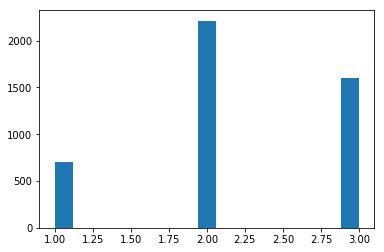

In [0]:
####################### In memory training #######################

####################### Import Data

x_42_eve, y_42_eve = newtub_to_array('/sets/42_VERIFIED_evening_20181113_NECTAR/')
x_ys_ratt, y_ys_ratt = newtub_to_array('/sets/ysance_horaire_rattrapage_20190523_NECTAR')
x_42_af, y_42_af = newtub_to_array('/sets/42_afternoon_20181113_NECTAR/')
x_sq_ah, y_sq_ah = newtub_to_array('/sets/lesquare_antihoraire_VERIFIED_morning_20181124_NECTAR/')
x_sq_h, y_sq_h = newtub_to_array('/sets/lesquare_horaire_VERIFIED_morning_20181124/')

x_r_nect, y_r_nect = newtub_to_array('/sets/ysance_nect_raph_20190614_NECTAR/')
x_sq_mo_nect, y_sq_mo_nect = newtub_to_array('/sets/lesquare_morning1_20190518_NECTAR')

#race 
x_sq_natural, y_sq_natural = newtub_to_array('/sets/lesquare_conduite_ratt_20190615/')
#x_sq_ratt, y_sq_ratt = newtub_to_array('/sets/set2/')

#validation data : last race
X_val, Y_val = newtub_to_array('/sets/lesquare_rattrapages_20190615//')
#X_val, Y_val = newtub_to_array('/sets/lesquare_NECTAR_20190518/')

X_train = np.concatenate((x_42_eve, 
                          x_ys_ratt, 
                          x_42_af, 
                          x_sq_h, 
                          x_sq_ah, x_r_nect, x_sq_mo_nect, x_sq_natural))
Y_train = np.concatenate((y_42_eve, 
                          y_ys_ratt, 
                          y_42_af, 
                          y_sq_h, 
                          y_sq_ah, y_r_nect, y_sq_mo_nect, y_sq_natural))

#del x_42_eve, x_ys_ratt, x_42_af, x_sq_h, x_sq_ah
#del y_42_eve, y_ys_ratt, y_42_af, y_sq_h, y_sq_ah

print(y_sq_natural.shape)
plot_class_histogram(Y_train)

In [0]:
####################### In memory training #######################

####################### Import Data

x_42_eve, y_42_eve = newtub_to_array('/sets/42_VERIFIED_evening_20181113_NECTAR/')
x_ys_ratt, y_ys_ratt = newtub_to_array('/sets/ysance_horaire_rattrapage_20190523_NECTAR')
x_42_af, y_42_af = newtub_to_array('/sets/42_afternoon_20181113_NECTAR/')
x_sq_ah, y_sq_ah = newtub_to_array('/sets/lesquare_antihoraire_VERIFIED_morning_20181124_NECTAR/')
x_sq_h, y_sq_h = newtub_to_array('/sets/lesquare_horaire_VERIFIED_morning_20181124/')

x_r_nect, y_r_nect = newtub_to_array('/sets/ysance_nect_raph_20190614_NECTAR/')
x_sq_mo_nect, y_sq_mo_nect = newtub_to_array('/sets/lesquare_morning1_20190518_NECTAR')

#race 
x_sq_natural, y_sq_natural = newtub_to_array('/sets/lesquare_conduite_ratt_20190615/')
#x_sq_ratt, y_sq_ratt = newtub_to_array('/sets/set2/')

#validation data : last race
X_val, Y_val = newtub_to_array('/sets/lesquare_rattrapages_20190615//')
#X_val, Y_val = newtub_to_array('/sets/lesquare_NECTAR_20190518/')

X_train = np.concatenate((x_42_eve, 
                          x_ys_ratt, 
                          x_42_af, 
                          x_sq_h, 
                          x_sq_ah, x_r_nect, x_sq_mo_nect, x_sq_natural))
Y_train = np.concatenate((y_42_eve, 
                          y_ys_ratt, 
                          y_42_af, 
                          y_sq_h, 
                          y_sq_ah, y_r_nect, y_sq_mo_nect, y_sq_natural))

#del x_42_eve, x_ys_ratt, x_42_af, x_sq_h, x_sq_ah
#del y_42_eve, y_ys_ratt, y_42_af, y_sq_h, y_sq_ah

print(y_sq_natural.shape)
plot_class_histogram(Y_train)

In [0]:
####################### intern challenge

x_42_eve, y_42_eve = newtub_to_array('/sets/gus/ysance_antihoraire_rattrapage_20190523/')
x_ys_ratt, y_ys_ratt = newtub_to_array('/sets/ysance_horaire_rattrapage_20190523_NECTAR')
x_42_af, y_42_af = newtub_to_array('/sets/42_afternoon_20181113_NECTAR/')
x_sq_ah, y_sq_ah = newtub_to_array('/sets/lesquare_antihoraire_VERIFIED_morning_20181124_NECTAR/')
x_sq_h, y_sq_h = newtub_to_array('/sets/lesquare_horaire_VERIFIED_morning_20181124/')

x_r_nect, y_r_nect = newtub_to_array('/sets/ysance_nect_raph_20190614_NECTAR/')
x_sq_mo_nect, y_sq_mo_nect = newtub_to_array('/sets/lesquare_morning1_20190518_NECTAR')

#race 
x_sq_natural, y_sq_natural = newtub_to_array('/sets/lesquare_conduite_ratt_20190615/')
#x_sq_ratt, y_sq_ratt = newtub_to_array('/sets/set2/')

#validation data : last race
X_val, Y_val = newtub_to_array('/sets/lesquare_rattrapages_20190615//')
#X_val, Y_val = newtub_to_array('/sets/lesquare_NECTAR_20190518/')

X_train = np.concatenate((x_42_eve, 
                          x_ys_ratt, 
                          x_42_af, 
                          x_sq_h, 
                          x_sq_ah, x_r_nect, x_sq_mo_nect, x_sq_natural))
Y_train = np.concatenate((y_42_eve, 
                          y_ys_ratt, 
                          y_42_af, 
                          y_sq_h, 
                          y_sq_ah, y_r_nect, y_sq_mo_nect, y_sq_natural))

#del x_42_eve, x_ys_ratt, x_42_af, x_sq_h, x_sq_ah
#del y_42_eve, y_ys_ratt, y_42_af, y_sq_h, y_sq_ah

print(y_sq_natural.shape)
plot_class_histogram(Y_train)

In [0]:
!echo 42_VERIFIED_evening_20181113
!ls /sets/42_VERIFIED_evening_20181113/ | wc -l 
!echo ysance_horaire_rattrapage_20190523_NECTAR
!ls /sets/ysance_horaire_rattrapage_20190523_NECTAR  | wc -l 
!echo 42_afternoon_20181113_NECTAR
!ls /sets/42_afternoon_20181113_NECTAR/  | wc -l
!echo lesquare_antihoraire_VERIFIED_morning_20181124
!ls /sets/lesquare_antihoraire_VERIFIED_morning_20181124/  | wc -l 
!echo lesquare_horaire_VERIFIED_morning_20181124
!ls /sets/lesquare_horaire_VERIFIED_morning_20181124/  | wc -l 

42_VERIFIED_evening_20181113
604
ysance_horaire_rattrapage_20190523_NECTAR
54
42_afternoon_20181113_NECTAR
37
lesquare_antihoraire_VERIFIED_morning_20181124
403
lesquare_horaire_VERIFIED_morning_20181124
1049


In [0]:
####################### Data Augmentation

from albumentations import (
    Compose, OneOf, HueSaturationValue, ToGray, MotionBlur, MedianBlur, Blur, ToFloat, FromFloat,
    RandomBrightness, RandomContrast, RandomGamma, Normalize, Cutout, RandomBrightnessContrast, RandomShadow, RandomSunFlare
)

AUGMENTATIONS_TRAIN = Compose([
    OneOf([
        RandomBrightnessContrast(brightness_limit=.6, contrast_limit=.6, p=0.6),
        Blur(blur_limit=3, p=0.6),
        RandomGamma(gamma_limit=(60, 180), p=0.6),
    ]),
    OneOf([
        RandomShadow(shadow_roi=(0, 0, 1, 1), shadow_dimension=3, p=0.3),
        RandomSunFlare(flare_roi=(0, 0, 1, 1), src_radius=60, angle_lower=0.3),
    ]),
    ToGray(p=0.1),
    #Cutout(p=1),
    TortueNormalize()
])

AUGMENTATIONS_TEST = Compose([
    TortueNormalize()
])


In [0]:
# fit model
epochs = 100
steps = 100
verbose = 1
min_delta = .0005
use_early_stop = True
batch_size=64

save_model_path='/content/saved_weights.hdf5'

####################### Create generators

train_gen = TortueInMemoryGenerator(X_train, Y_train, batch_size, augmentations=AUGMENTATIONS_TRAIN, flip_proportion=.5)

valid_gen = TortueInMemoryGenerator(X_val, Y_val, batch_size, augmentations=AUGMENTATIONS_TEST, flip_proportion=.4)


####################### Train
model = default_categorical()

hist = model.fit_generator(train_gen,
                           epochs=epochs,
                           validation_data=valid_gen,
                           use_multiprocessing=False,
                           callbacks=callbacks_list)


In [0]:
model.evaluate(X_val/255-.5, Y_val)

71/71 [==============================] - 0s 631us/step


[0.17904188061579013, 0.9436619718309859]

In [0]:
# daily rattrage
model.evaluate(X_val/255-.5, Y_val)

1552/1552 [==============================] - 1s 408us/step


[0.5304714727033045, 0.8060567010309279]

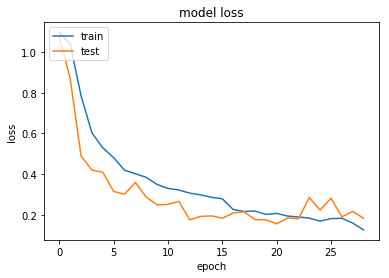

In [0]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
n = 13
plt.imshow(x_val[n]+.5)
plt.title(str(np.around(model.predict(x_val[n].reshape((1,) + x_val[n].shape)), 3)))

In [0]:
a = np.arange(55)
np.random.shuffle(a)
a

array([47, 41, 16, 53, 35, 52, 37, 30, 34, 28, 17, 12, 50, 23, 31,  3,  7,
       44, 38, 42, 19, 11, 36, 27,  4,  8, 26, 15, 24, 32,  9, 20, 39, 49,
       29, 25,  6, 14,  1, 18, 48, 46, 40,  5, 10, 13, 45, 33,  0,  2, 21,
       43, 51, 22, 54])

In [0]:
from albumentations import RandomSunFlare, RandomShadow, RandomFog

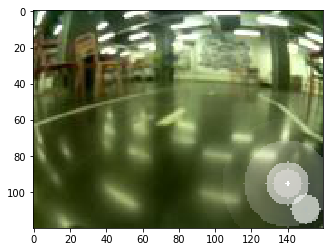

In [0]:
#aug_im = RandomBrightnessContrast(brightness_limit=.6, contrast_limit=.6, p=1)
#aug_im = Blur(blur_limit=3, p=1)
aug_im = RandomSunFlare(flare_roi=(0, 0, 1, 1), src_radius=60, p=1)
#aug_im = RandomShadow(shadow_roi=(0, 0, 1, 1), shadow_dimension=3, p=1)
#aug_im = RandomSunFlare(src_radius=10, p=1)
#aug_im = RandomFog(fog_coef_lower=.2, fog_coef_upper=.09, p=1)
im = aug_im(image=X_train[0])

plt.imshow((im['image']))

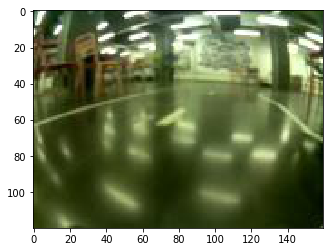

In [0]:
plt.imshow(X_train[0])

In [0]:
Y_train[0]

array([0., 0., 1.])

In [0]:
predict_probas = model.predict(x_val)
t_losses = categorical_crossentropy(convert_to_tensor(y_val, dtype=tf.float64), 
                                    convert_to_tensor(predict_probas, dtype=tf.float64))
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    print(t_losses.eval())

[3.19671510e-02 1.31908868e+01 3.32630791e-03 3.33697187e+00
 1.27547284e+01 1.42291637e+00 3.92478127e-02 3.97259272e-03
 8.62507727e-04 1.61180957e+01 9.06333358e-01 1.45630279e+00
 6.20919412e-03 1.92624216e-02 1.68483167e-02 1.30887880e-03
 5.43855050e-03 2.18601019e-01 2.40191569e-02 4.47124460e-03
 5.48574447e-03 9.75629908e+00 5.16762858e-02 3.44410458e-02
 2.09667087e+00 2.61412044e-05 3.06261010e-01 1.22083037e-04
 5.40911972e-07 7.56213219e-01 4.20165783e+00 4.43208909e-01
 4.35531150e-02 4.70243128e+00 9.09538368e+00 2.06575790e-01
 3.54398024e-03 2.39705570e+00 2.22789012e+00 6.27234902e-01
 3.34498847e-01 1.83864029e-04 1.61180957e+01 3.75709712e-01
 9.50835852e-02 5.06255590e-01 1.35471873e+00 1.87767140e-03]


In [0]:
X_train

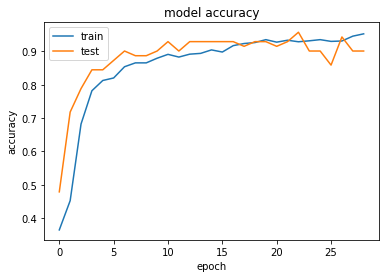

In [0]:
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# save model
#cp /content/last_saved_weights.hdf5 /gdrive/My\ Drive/franklin/models/augmented_turtle2_20190614.hdf5

In [0]:
cp /content/last_saved_weights.hdf5 /content/aug_turtle_polished1.hdf5

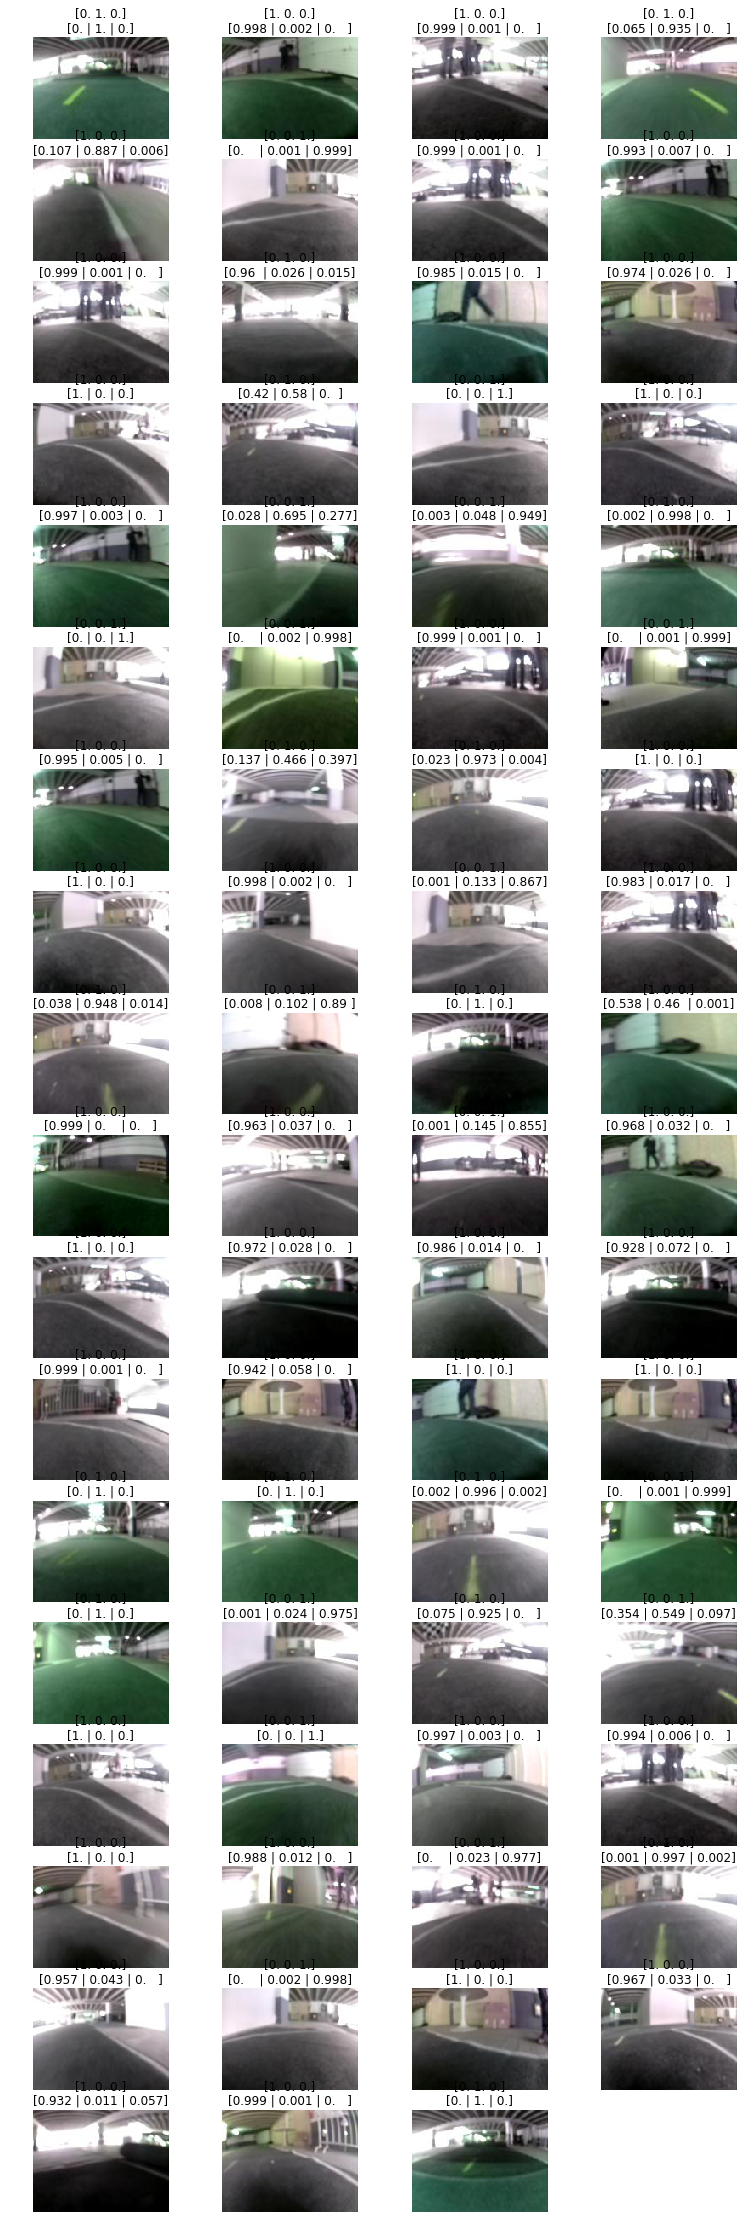

In [0]:
from tensorflow.python.keras.utils import to_categorical

def predicted_right(y_val, y_probas):
  y_hat = to_categorical(np.argmax(y_probas, axis=1))
  right_val = [np.array_equal(yhat, y) for yhat, y in zip(y_hat, y_val)]
  return np.array(right_val)

def viz_validation(x_val, y_val, y_hat):
  plt.figure(figsize=(13,40))

  for n in range(len(y_val)):
    plt.subplot(1+(len(y_val) // 4), 4, n+1)
    plt.imshow(x_val[n])
    plt.title(str(y_val[n])+'\n'+ np.array2string(np.around(y_hat[n], 3), separator=' | '))
    plt.axis('off')
    
y_probas = model.predict(X_val/255-.5)

right_val = predicted_right(Y_val, y_probas)

viz_validation(X_val, Y_val, y_probas)

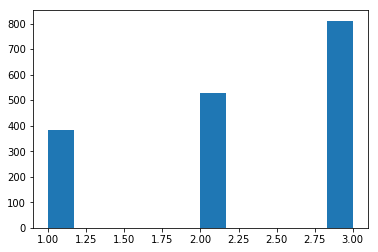

In [0]:
def plot_class_histogram(Y):
    '''
    Y : categorical numpy array'''
    a = [1, 2, 3]
    fi = [sum(n * a) for n in Y]
    
    plt.hist(fi, bins='auto')

plot_class_histogram(Y_train)

In [0]:
from albumentations.core.transforms_interface import ImageOnlyTransform 

def augment_and_show(aug, image):
    image = aug(image=image)['image']
    plt.figure(figsize=(4, 3.5))
    plt.imshow(image)
    return image
  
class TortueNormalize(ImageOnlyTransform):
    """Normalization used in Tortue Rapide:
    Divide pixel values by 255 and subtract .5

    Targets:
        image

    Image types:
        uint8, float32
    """

    def __init__(self, always_apply=False, p=1.0):
      super(TortueNormalize, self).__init__(always_apply, p)
      self.p = p
      self.always_apply = always_apply
    
    def apply(self, image, **params):
        return image/255.0 - .5

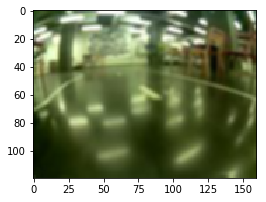

In [0]:
aug = Blur(p=1)
augment_and_show(aug, X_train[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


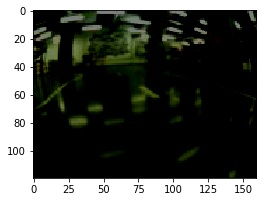

In [0]:
aug = TortueNormalize(p=1)
augted_im = augment_and_show(aug, X_train[0])
augted_im

In [0]:
np.min(augted_im)

-0.5

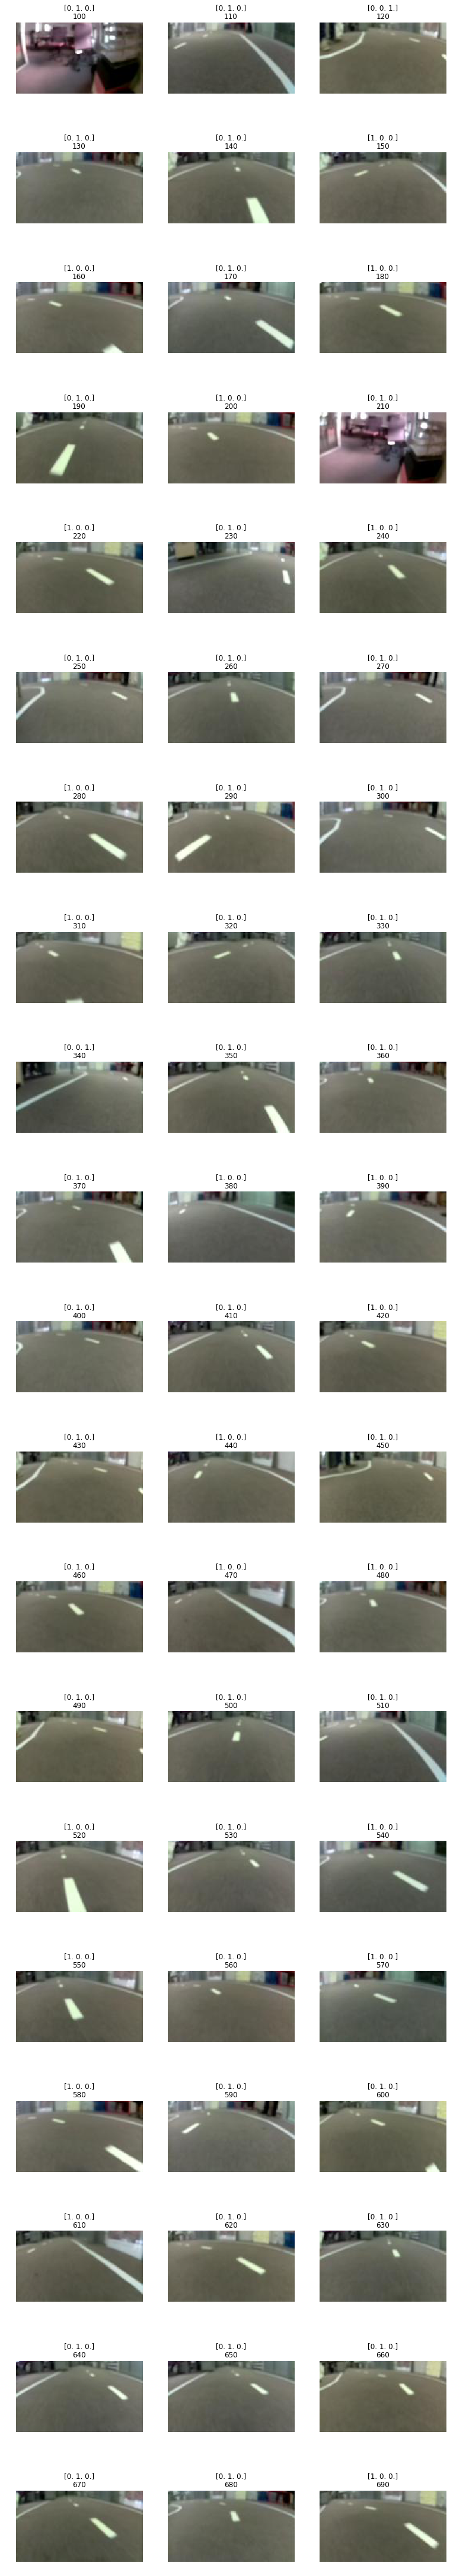

In [0]:
step=2
gap = 10
start = 5*step*gap

straight = [np.array_equal(y, np.array([0, 1, 0])) for y in y_val]         

x_viz, y_viz = newtub_to_array('/content/abbey_90_20190513')

plt.figure(figsize=(13,80))
for n in range(60):
  plt.subplot(20,3,n+1)
  plt.imshow(x_viz[start+n*gap][30:])
  plt.title(str(y_viz[start+n*gap]) + '\n' + str(start+n*gap))
  plt.axis('off')

In [0]:
from training_utils import horizontal_flip_inplace

In [0]:
c, u = horizon(X_train[0:4], Y_train[0:4], proportion=1)